In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h3
import xgboost as xgb

In [37]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 


# XGB 指定參數

In [48]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=3,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)
# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717


[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17177
[6]	validation_0-rmse:0.16906
[7]	validation_0-rmse:0.16359
[8]	validation_0-rmse:0.15430
[9]	validation_0-rmse:0.14877
[10]	validation_0-rmse:0.14466
[11]	validation_0-rmse:0.14188
[12]	validation_0-rmse:0.14336
[13]	validation_0-rmse:0.14145
[14]	validation_0-rmse:0.13830
[15]	validation_0-rmse:0.13515
[16]	validation_0-rmse:0.13363
[17]	validation_0-rmse:0.13014
[18]	validation_0-rmse:0.12816
[19]	validation_0-rmse:0.12567
[20]	validation_0-rmse:0.12576
[21]	validation_0-rmse:0.12480
[22]	validation_0-rmse:0.12508
[23]	validation_0-rmse:0.12501
[24]	validation_0-rmse:0.12522
[25]	validation_0-rmse:0.12447
[26]	validation_0-rmse:0.12380
[27]	validation_0-rmse:0.12462
[28]	validation_0-rmse:0.12306
[29]	validation_0-rmse:0.12252
[30]	validation_0-rmse:0.12137
[31]	validation_0-rmse:0.12029
[32]	validation_0-rmse:0.12031
[33]	validation_0-rmse:0.12040
[34]	validation_

# XGBoost SHAP

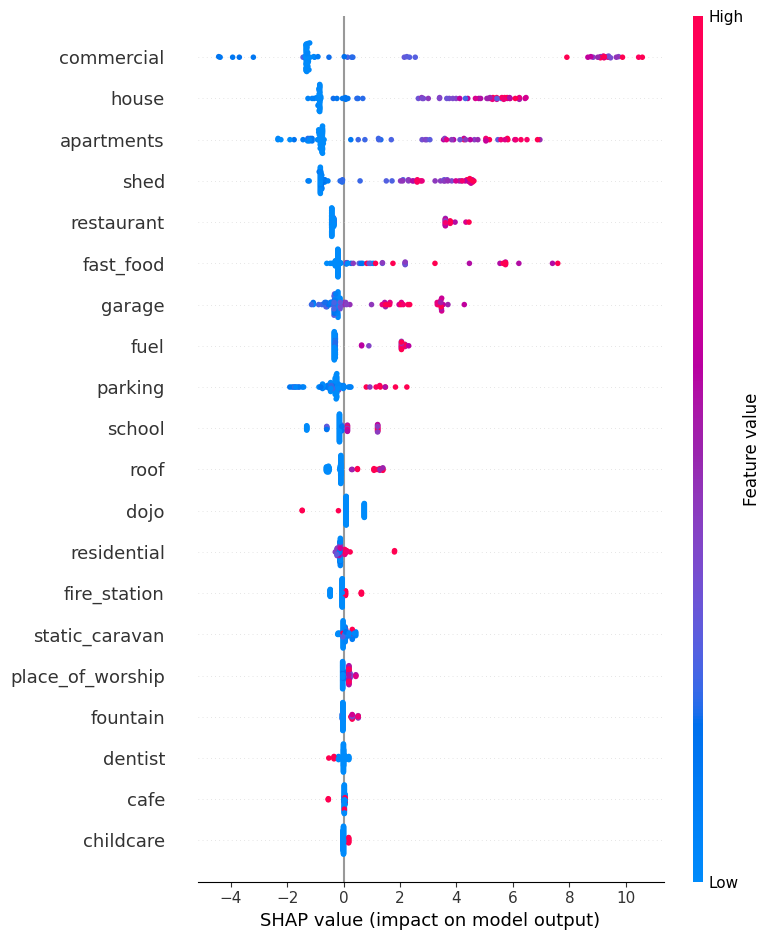

In [39]:
import shap
import matplotlib.pyplot as plt

# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_values_test = explainer.shap_values(X_test_reguli)*ohca_reguli_inverse

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(shap_values_test, X_test_reguli,feature_names, max_display=20)
# # 顯示每個特徵的平均影響力 (特徵重要性條形圖)
# shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])

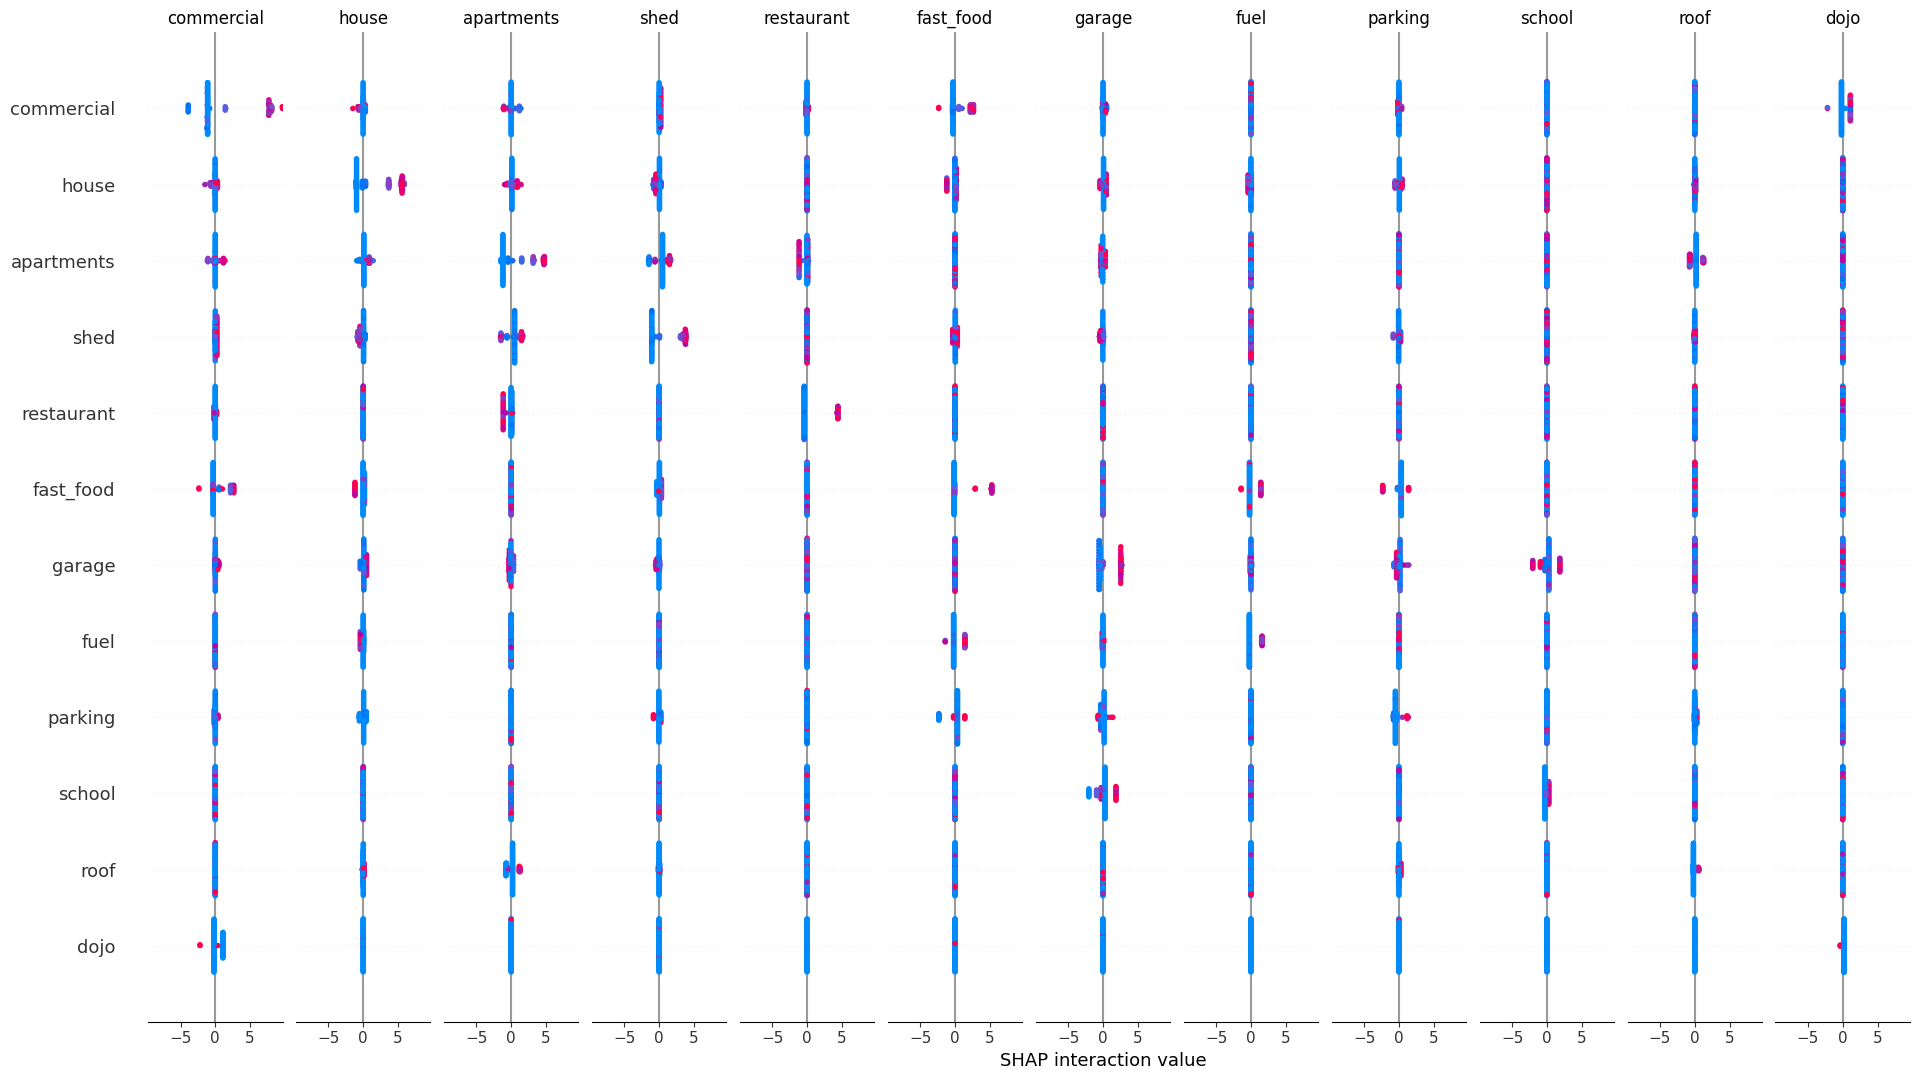

<Figure size 640x480 with 0 Axes>

In [40]:
# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_interaction_values = explainer.shap_interaction_values(X_test_reguli)*ohca_reguli_inverse

# 提取第一個樣本的第 0 和第 1 個特徵的交互值
interaction_0_1 = shap_interaction_values[0][0, 1]

# 繪製 SHAP 交互值矩陣圖
shap.summary_plot(shap_interaction_values, X_test_reguli,feature_names,max_display=12)

# XGBoost 特徵解釋

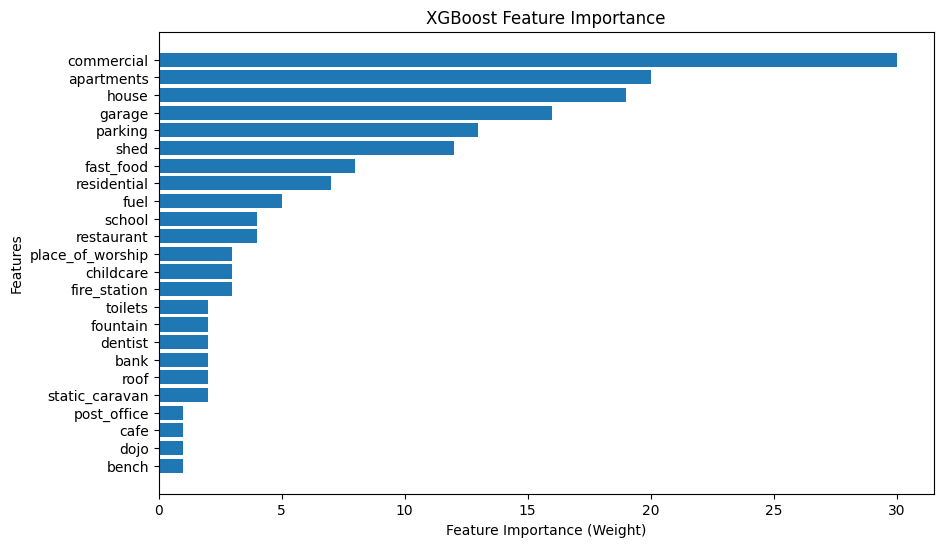

In [41]:
# 取得特徵重要性
importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# 轉換為排序好的列表
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 轉換 'fXX' 為對應的 feature_names[XX]
updated_importance = [(feature_names[int(f[1:])], score) for f, score in sorted_features]

features, values = zip(*updated_importance)

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(features, values)
plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()  # 讓重要性高的特徵排在上方
plt.show()

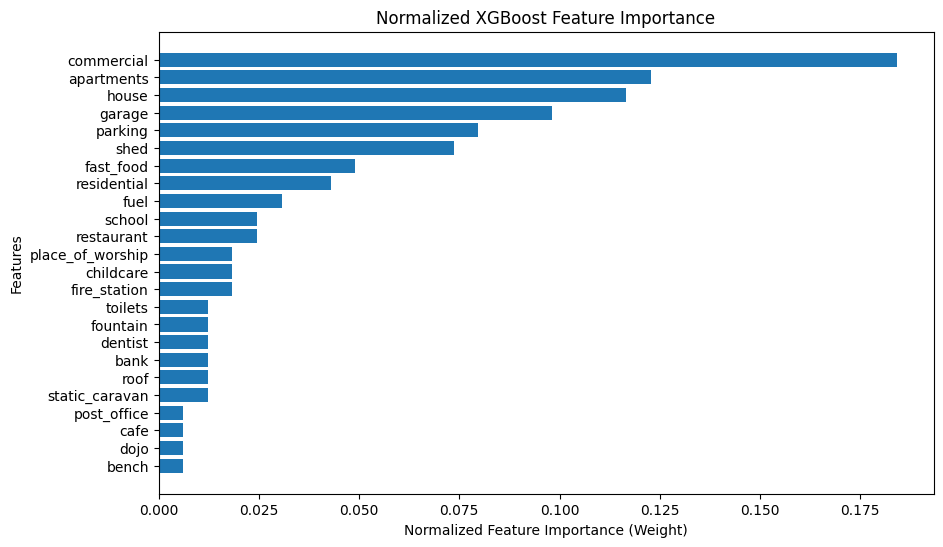

In [42]:
# 取得特徵重要性
importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# 轉換為排序好的列表
sorted_features = sorted(importance.items(), key=lambda x: x[1], reverse=True)

# 將 'fXX' 轉換成對應的 feature_names[XX]
updated_importance = [(feature_names[int(f[1:])], score) for f, score in sorted_features]

# 分離名稱與分數
features, values = zip(*updated_importance)

# 歸一化：除以總和，讓所有值加總為1
normalized_values = [v / sum(values) for v in values]

# 繪製條形圖
plt.figure(figsize=(10, 6))
plt.barh(features, normalized_values)
plt.xlabel("Normalized Feature Importance (Weight)")
plt.ylabel("Features")
plt.title("Normalized XGBoost Feature Importance")
plt.gca().invert_yaxis()  # 讓重要性高的特徵排在上方
plt.show()


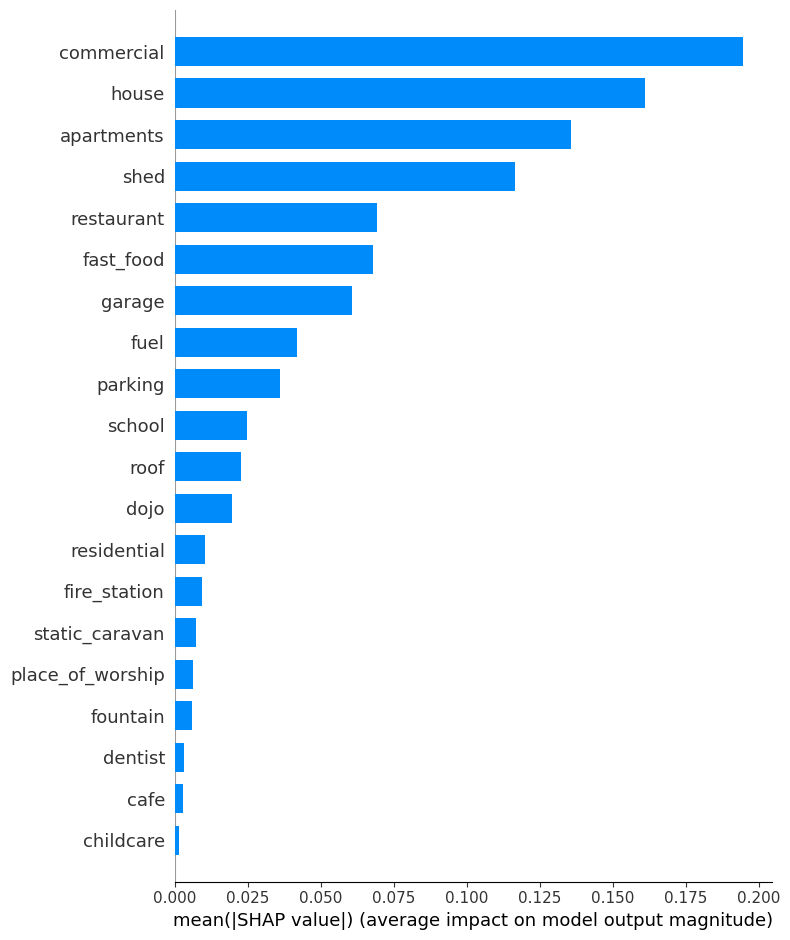

In [43]:

# 計算 SHAP 值（對測試資料）
explainer = shap.TreeExplainer(best_xgb_model)
shap_values_test = explainer.shap_values(X_test_reguli)

# SHAP 特徵重要性：對每個特徵取絕對值的平均值
mean_abs_shap = np.abs(shap_values_test).mean(axis=0)

# 歸一化：總和為 1
normalized_shap = shap_values_test / np.sum(mean_abs_shap)
# shap_values_test = explainer.shap_values(X_test_reguli)

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(normalized_shap, X_test_reguli,feature_names , plot_type="bar",  max_display=20)

# 查看SHAP 是否逼近f(x)

In [44]:
# 計算 SHAP 值 (針對訓練集)
shap_values_train = explainer.shap_values(X_train_reguli)*ohca_reguli_inverse

# 使用模型預測的 base value（ϕ₀）
base_value_np = explainer.expected_value*ohca_reguli_inverse # or y_head_train.mean()

predicted_value_list = []
shap_predicted_value_list = []

for index in range(len(shap_values_train)):
    shap_values_np = shap_values_train[index]
    predicted_value = y_head_train[index]  # 單筆預測
    shap_predicted_value = base_value_np + shap_values_np.sum()
    predicted_value_list.append(predicted_value)
    shap_predicted_value_list.append(shap_predicted_value)

# 轉為 NumPy
predicted_value_array = np.array(predicted_value_list)
shap_predicted_value_array = np.array(shap_predicted_value_list)

# MAE
train_mae = np.abs(predicted_value_array - shap_predicted_value_array)
train_ans_mae = train_mae.mean()
print('MAE of SHAP = ', train_ans_mae)

# R²
train_ss_residual = np.sum((predicted_value_array - shap_predicted_value_array) ** 2)
train_ss_total = np.sum((predicted_value_array - predicted_value_array.mean()) ** 2)
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

MAE of SHAP =  7.704618465469544e-07
R² of train set=  0.9999999999999892


Text(0, 0.5, "g(x')")

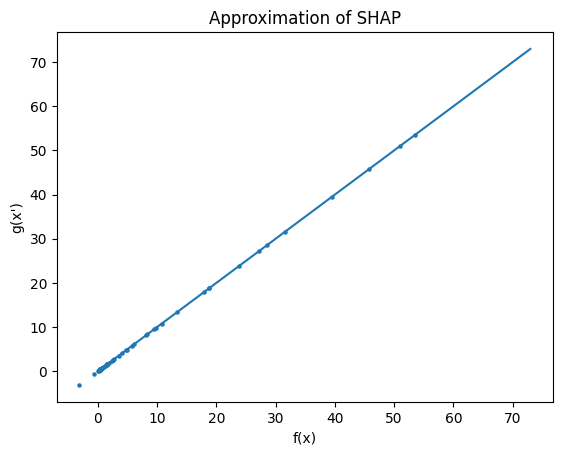

In [45]:
plt.scatter(predicted_value_list,
            shap_predicted_value_list,
            s = 5)
plt.plot([0, 73], [0, 73])
plt.title('Approximation of SHAP')
plt.xlabel('f(x)')
plt.ylabel("g(x')")

# 印出所有feature


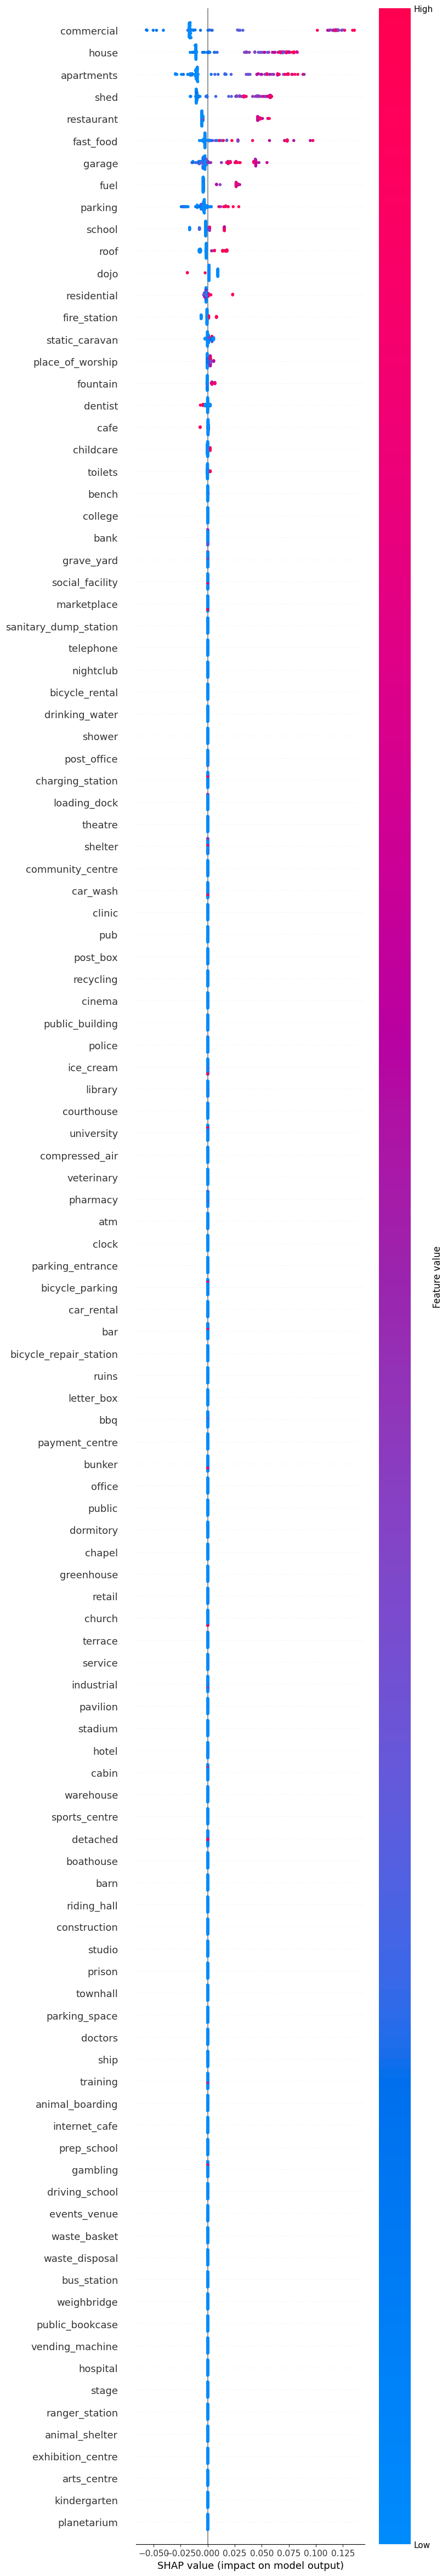

In [46]:
shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])

# 深度更深的tree

In [50]:
# 定義XGBoost模型並指定參數
best_xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=277,
    early_stopping_rounds=10,
    # 以下是您指定的參數值，請根據需要修改這些值
    max_depth=10,               # 樹的最大深度
    learning_rate=0.2,         # 學習率
    n_estimators=100,          # 樹的數量
    subsample=0.7,            # 每棵樹隨機採樣的比例 0.7
    colsample_bytree=0.7,      # 每棵樹使用的特徵比例 0.7
    gamma=0,                # 控制節點分裂的最小增益
    reg_alpha=0.1,            # L1正則化強度 0
    reg_lambda=1,           # L2正則化強度
    min_child_weight=3        # 每個葉子節點的最小樣本權重
)
# 訓練模型
best_xgb_model.fit(
    X_train_reguli, y_train_reguli,
    eval_set=[(X_test_reguli, y_test_reguli)],  # 提供測試集進行早停監控
    verbose=True
)

# 預測訓練集結果
y_head_train = best_xgb_model.predict(X_train_reguli) * ohca_reguli_inverse
y_train = y_train_reguli * ohca_reguli_inverse
# 預測測試集結果
y_head_test = best_xgb_model.predict(X_test_reguli) * ohca_reguli_inverse
y_test = y_test_reguli * ohca_reguli_inverse


#評估成效
train_mae = np.abs(y_head_train-y_train)
train_ans_mae = train_mae.sum()/train_mae.shape[0]
print('MAE of train set= ',train_ans_mae)
# 計算殘差變異
train_ss_residual = np.sum((y_train - y_head_train) ** 2)
# 計算總變異量
train_ss_total = np.sum((y_train - np.mean(y_train)) ** 2)
# 計算 R²
train_r_squared = 1 - (train_ss_residual / train_ss_total)
print("R² of train set= ", train_r_squared)

test_mae = np.abs(y_head_test-y_test)
test_ans_mae = test_mae.sum()/test_mae.shape[0]
print('MAE of test set= ',test_ans_mae)
# 計算殘差變異
test_ss_residual = np.sum((y_test - y_head_test) ** 2)
# 計算總變異量
test_ss_total = np.sum((y_test - np.mean(y_test)) ** 2)
# 計算 R²
test_r_squared = 1 - (test_ss_residual / test_ss_total)
print("R² of test set= ", test_r_squared)

[0]	validation_0-rmse:0.24953
[1]	validation_0-rmse:0.22717
[2]	validation_0-rmse:0.21675
[3]	validation_0-rmse:0.19437
[4]	validation_0-rmse:0.17980
[5]	validation_0-rmse:0.17192
[6]	validation_0-rmse:0.16992
[7]	validation_0-rmse:0.16451
[8]	validation_0-rmse:0.15527
[9]	validation_0-rmse:0.14967
[10]	validation_0-rmse:0.14745
[11]	validation_0-rmse:0.14460
[12]	validation_0-rmse:0.14605
[13]	validation_0-rmse:0.14343
[14]	validation_0-rmse:0.13810
[15]	validation_0-rmse:0.13525
[16]	validation_0-rmse:0.13333
[17]	validation_0-rmse:0.13017
[18]	validation_0-rmse:0.12817
[19]	validation_0-rmse:0.12771
[20]	validation_0-rmse:0.12677
[21]	validation_0-rmse:0.12555
[22]	validation_0-rmse:0.12553
[23]	validation_0-rmse:0.12531
[24]	validation_0-rmse:0.12413
[25]	validation_0-rmse:0.12337
[26]	validation_0-rmse:0.12239
[27]	validation_0-rmse:0.12289
[28]	validation_0-rmse:0.12139
[29]	validation_0-rmse:0.12075
[30]	validation_0-rmse:0.11960
[31]	validation_0-rmse:0.11856
[32]	validation_0-

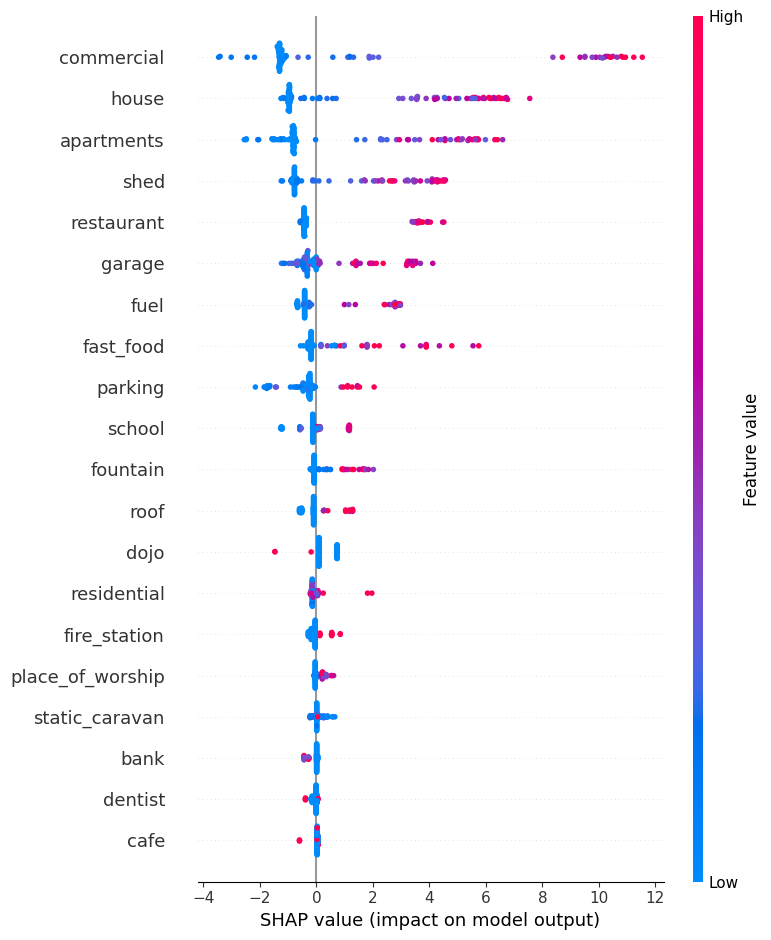

In [51]:
# 初始化 SHAP 解釋器
explainer = shap.TreeExplainer(best_xgb_model)

# 計算 SHAP 值 (對測試集數據進行解釋)
shap_values_test = explainer.shap_values(X_test_reguli)*ohca_reguli_inverse

# Get the shap values from my test data
test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

shap.summary_plot(shap_values_test, X_test_reguli,feature_names, max_display=20)
# # 顯示每個特徵的平均影響力 (特徵重要性條形圖)
# shap.summary_plot(shap_values_test, X_test_reguli,feature_names,max_display=X_test_reguli.shape[1])